# Walkthrough notebook for the APPLESOSS (A Producer of ProfiLEs for SOSS) Module
Construct spatial profiles based on a given observed dataset for the first and second SOSS orders to be used as the spatprofile reference file in the ATOCA algorithm.

In [1]:
from astropy.io import fits
from matplotlib.colorbar import Colorbar
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sys import path
soss_path = '/Users/michaelradica/Documents/GitHub/jwst-mtl/'
path.insert(1, soss_path)

from SOSS.dms.soss_centroids import get_soss_centroids
from SOSS.extract.applesoss.utils import replace_badpix
from SOSS.extract.applesoss import applesoss

/Users/michaelradica/.anaconda3/envs/soss/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/michaelradica/Documents/GitHub/BEARS/BEARS_ref-files/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/michaelradica/.anaconda3/envs/soss/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/michaelradica/Documents/GitHub/BEARS/BEARS_ref-files/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/michaelradica/.anaconda3/envs/soss/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/michaelradica/Documents/GitHub/BEARS/BEARS_ref-files/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-034 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-045
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


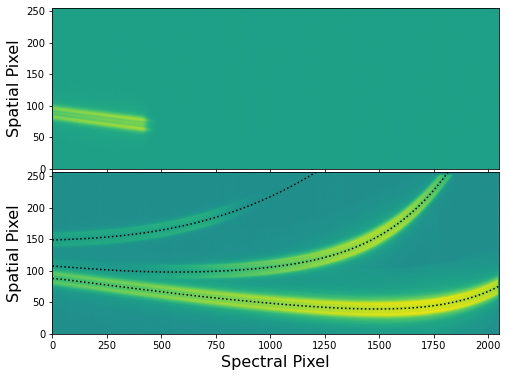

In [2]:
# Get some simulated observations as a test case.
filepath = '/Users/michaelradica/transfer/IDTSOSS_clear_noisy_1_flatfieldstep.fits'
clear = fits.getdata(filepath, 1)
clear = np.nansum(clear, axis=0)
error = fits.getdata(filepath, 2)
error = np.sqrt(np.nansum(error**2, axis=0))
filepath = '/Users/michaelradica/transfer/IDTSOSS_f277_noisy_1_flatfieldstep.fits'
f277 = fits.open(filepath)[1].data
f277 = np.nansum(f277, axis=0)

# Add a floor level such that all pixels are positive
# Are we introducing any biases by doing this?
floor = np.nanpercentile(clear, 0.1)
clear -= floor
floor_f277 = np.nanpercentile(f277, 0.1)
f277 -= floor_f277

# Replace bad pixels.
clear = replace_badpix(clear, np.isnan(np.log10(clear)))
f277 = replace_badpix(f277, np.isnan(np.log10(f277)))

# Get the trace centroids for all three orders.
cen = get_soss_centroids(clear, subarray='SUBSTRIP256')

# Plot the data frames
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow(np.log10(f277), origin='lower', aspect='auto')
ax1.set_ylabel('Spatial Pixel', fontsize=16)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow(np.log10(clear), origin='lower', aspect='auto')
ax2.plot(cen['order 1']['X centroid'], cen['order 1']['Y centroid'], ls=':', c='black')
ax2.plot(cen['order 2']['X centroid'], cen['order 2']['Y centroid'], ls=':', c='black')
ax2.plot(cen['order 3']['X centroid'], cen['order 3']['Y centroid'], ls=':', c='black')
ax2.set_xlabel('Spectral Pixel', fontsize=16)
ax2.set_ylabel('Spatial Pixel', fontsize=16)
ax2.set_ylim(0, 256)

plt.subplots_adjust(wspace=0, hspace=0.02)
plt.show()

# Add back the floor level
clear += floor
f277 += floor_f277

The ```EmpiricalProfile``` class of APPLESOSS is the workhorse of this module. To initialize it, it requires a CLEAR as well as an F277W exposure data frame, and a bad pixel mask (for centroiding purposes). Optional arguments are the amount of padding to add around the edges of the frames, as well as the factor of oversampling. 

Call ```build_empirical_profile``` once the class is initialized to construct the model first and second order spatial profiles. Optional arguments are ```normalize``` to normalize each column such that the flux adds to unity, as well as ```lazy```, which activates the "lazy" mode (ask me if you're interested).

Afterwards, the ```save_to_file``` method can be called to save the first and second order profiles to an external file for use with ATOCA. Note that they will not be formatted in the correct manner to be used directly as ATOCA spatprofile reference files.

Starting the APPLESOSS module.

 Initial processing...
  Getting trace centroids...


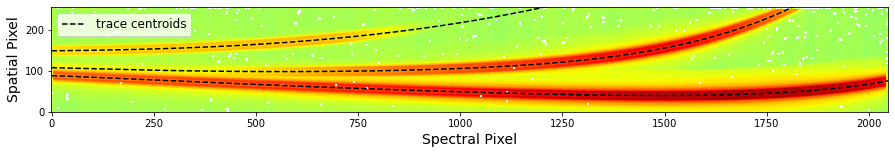

  0%|          | 0/2048 [00:00<?, ?it/s]

  Starting the first order model...
  Lazy method selected...


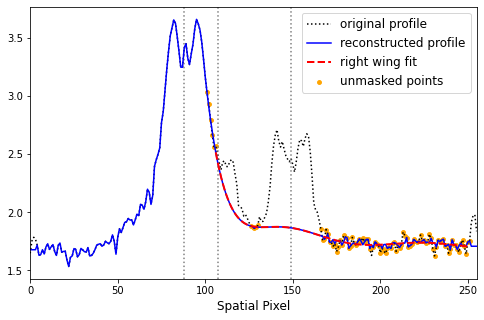

100%|██████████| 2048/2048 [01:03<00:00, 32.01it/s]


  Starting the second order trace model...


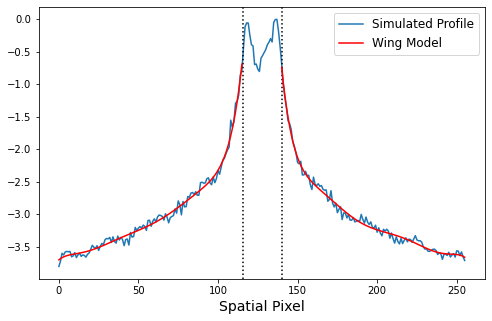


Done.


In [3]:
bad_pix = np.isnan(clear)
spat_prof = applesoss.EmpiricalProfile(clear, f277, bad_pix, verbose=3)
spat_prof.build_empirical_profile(normalize=False, lazy=False)

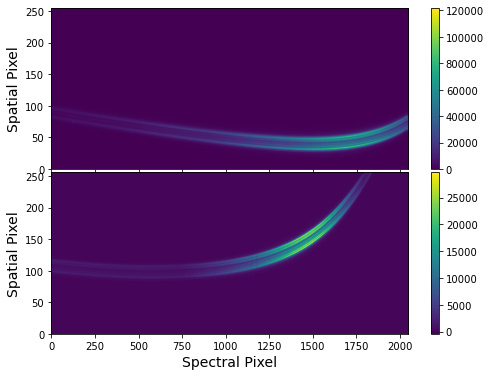

In [5]:
# Show the spatial profile models for each order.
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow(spat_prof.order1, origin='lower', aspect='auto')
plt.colorbar()
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow(spat_prof.order2, origin='lower', aspect='auto')
plt.colorbar()
ax2.set_xlabel('Spectral Pixel', fontsize=14)
ax2.set_ylabel('Spatial Pixel', fontsize=14)

plt.xlim(0, 2048)
plt.ylim(0, 256)

plt.subplots_adjust(hspace=0.02)
plt.show()

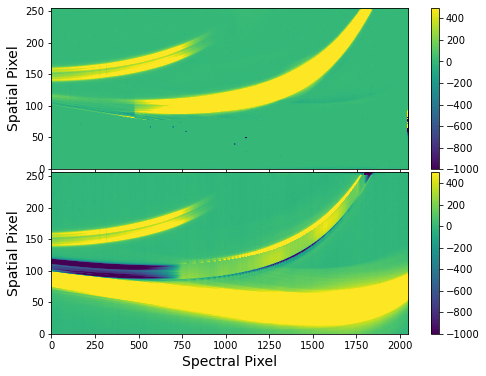

In [7]:
# Example decontamination.
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow(clear - spat_prof.order1, origin='lower', aspect='auto', vmin=-1e3, vmax=5e2)
plt.colorbar()
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow(clear - spat_prof.order2, origin='lower', aspect='auto', vmin=-1e3, vmax=5e2)
plt.colorbar()
ax2.set_xlabel('Spectral Pixel', fontsize=14)
ax2.set_ylabel('Spatial Pixel', fontsize=14)

plt.xlim(0, 2048)
plt.ylim(0, 256)

plt.subplots_adjust(hspace=0.02)
plt.show()

In [12]:
# Column normalize the profiles
spat_prof.order1 /= np.sum(spat_prof.order1, axis=0)
spat_prof.order2 /= np.sum(spat_prof.order2, axis=0)

In [13]:
# Get simulated reference profiles
order1 = fits.getdata('/Users/michaelradica/transfer/ref_specprofile.fits', 1)
binned_array = order1[40:-40, 40:-40].reshape(256, 2, 2048, 2)
order1 = binned_array.mean(-1).sum(1)
order1 /= np.sum(order1, axis=0)
order2 = fits.getdata('/Users/michaelradica/transfer/ref_specprofile.fits', 2)
binned_array = order2[40:-40, 40:-40].reshape(256, 2, 2048, 2)
order2 = binned_array.mean(-1).sum(1)
order2 /= np.sum(order2, axis=0)

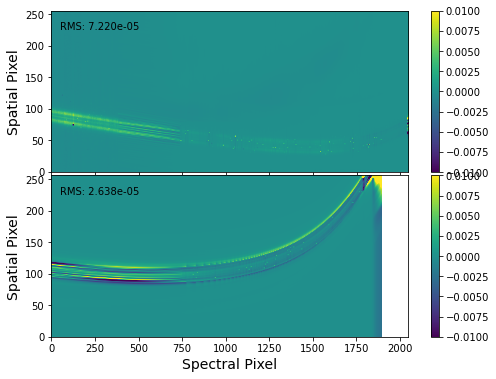

In [8]:
# Compare the model spatial profiles to the reference spatial profiles that were seeded 
# into the original simulation.
# Original
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow((order1 - spat_prof.order1), origin='lower', aspect='auto', vmax=0.01, vmin=-0.01)
plt.colorbar()
rms = np.sqrt(np.nanmedian((order1 - spat_prof.order1)**2))
plt.text(50, 225, 'RMS: {:.3e}'.format(rms))
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow((order2 - spat_prof.order2), origin='lower', aspect='auto', vmax=0.01, vmin=-0.01)
plt.colorbar()
rms = np.sqrt(np.nanmedian((order2 - spat_prof.order2)**2))
plt.text(50, 225, 'RMS: {:.3e}'.format(rms))
ax2.set_xlabel('Spectral Pixel', fontsize=14)
ax2.set_ylabel('Spatial Pixel', fontsize=14)

plt.xlim(0, 2048)
plt.ylim(0, 256)

plt.subplots_adjust(hspace=0.02)
plt.show()

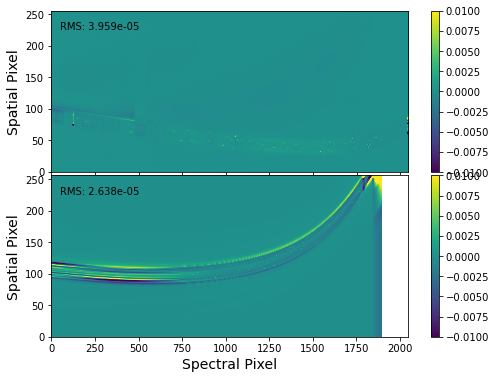

In [14]:
# Lazy
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow((order1 - spat_prof.order1), origin='lower', aspect='auto', vmax=0.01, vmin=-0.01)
plt.colorbar()
rms = np.sqrt(np.nanmedian((order1 - spat_prof.order1)**2))
plt.text(50, 225, 'RMS: {:.3e}'.format(rms))
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow((order2 - spat_prof.order2), origin='lower', aspect='auto', vmax=0.01, vmin=-0.01)
plt.colorbar()
rms = np.sqrt(np.nanmedian((order2 - spat_prof.order2)**2))
plt.text(50, 225, 'RMS: {:.3e}'.format(rms))
ax2.set_xlabel('Spectral Pixel', fontsize=14)
ax2.set_ylabel('Spatial Pixel', fontsize=14)

plt.xlim(0, 2048)
plt.ylim(0, 256)

plt.subplots_adjust(hspace=0.02)
plt.show()

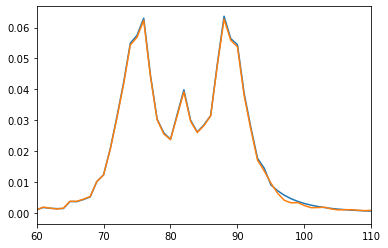

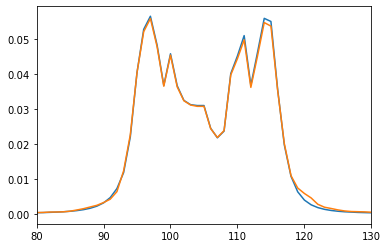

In [15]:
plt.plot((spat_prof.order1[:, 150]))
plt.plot((order1[:, 150]))
plt.xlim(60, 110)
plt.show()

plt.plot((spat_prof.order2[:, 1000]))
plt.plot((order2[:, 1000]))
plt.xlim(80, 130)
plt.show()

### Now try everything with the data from CV3

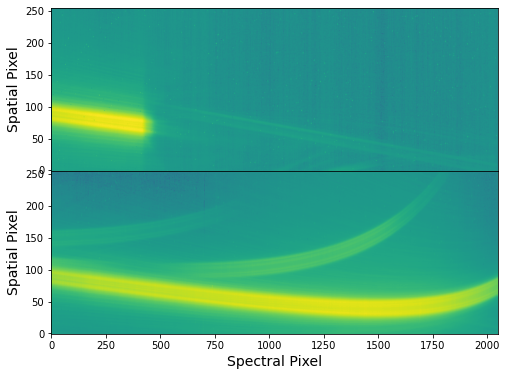

In [151]:
# Open the CV3 CLEAR and F277W and process in the same way as before.
filepath = '/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Input_Files/cv3_clear.fits'
clear_cv3 = fits.getdata(filepath, 0)[::-1]
clear_cv3[85, 1059] = np.nan # one weird bad pixel
filepath = '/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Input_Files/cv3_f277.fits'
f277_cv3 = fits.getdata(filepath, 0).transpose()[::-1, ::-1]

# Add a floor level such that all pixels are positive
floor_cv3 = np.nanpercentile(clear_cv3, 0.1)
clear_cv3 -= floor_cv3
floor_f277_cv3 = np.nanpercentile(f277_cv3, 0.1)
f277_cv3 -= floor_f277_cv3

# Replace bad pixels.
clear_cv3 = replace_badpix(clear_cv3, np.isnan(np.log10(clear_cv3)))
f277_cv3 = replace_badpix(f277_cv3, np.isnan(np.log10(f277_cv3)))

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow(np.log10(f277_cv3), origin='lower', aspect='auto')
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow(np.log10(clear_cv3), origin='lower', aspect='auto')
ax2.set_xlabel('Spectral Pixel', fontsize=14)
ax2.set_ylabel('Spatial Pixel', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Add back the floor level
clear_cv3 += floor_cv3
f277_cv3 += floor_f277_cv3

Starting the APPLESOSS module.

 Initial processing...
  Getting trace centroids...


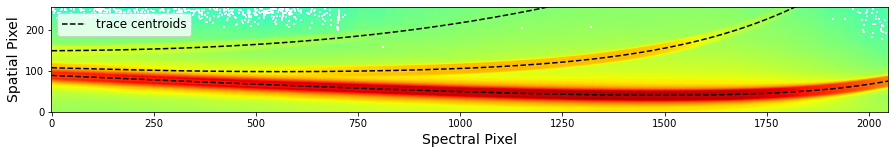

  Starting the first order trace model...
   Calibrating trace widths...
   Getting anchor profiles...


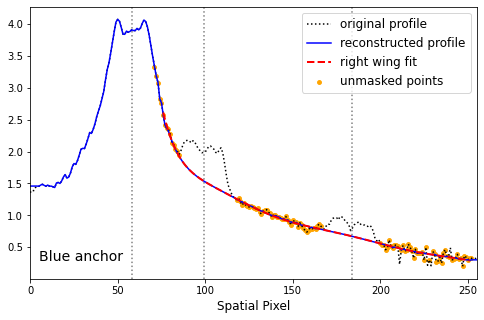

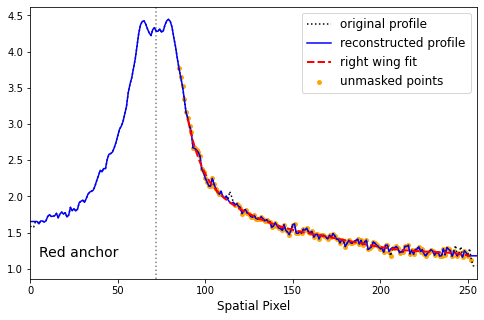

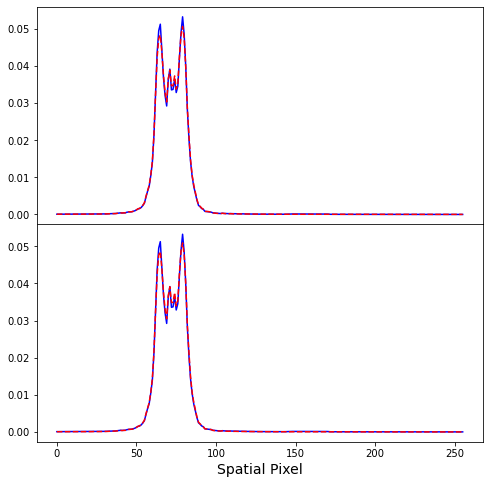

   Interpolating trace...


100%|██████████| 353/353 [00:00<00:00, 5230.03it/s]

   Stitching data and reconstructing wings...



100%|██████████| 386/386 [00:10<00:00, 36.81it/s]


   Rescaling first order to native flux level...


100%|██████████| 2048/2048 [00:10<00:00, 189.38it/s]


  Starting the second order trace model...


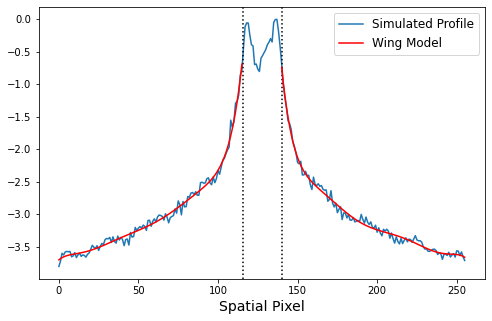


Done.


In [153]:
# Build the spatial profile models.
bad_pix = np.isnan(clear_cv3)
spat_prof_cv3 = applesoss.EmpiricalProfile(clear_cv3, f277_cv3, bad_pix, verbose=3)
spat_prof_cv3.build_empirical_profile(normalize=True)

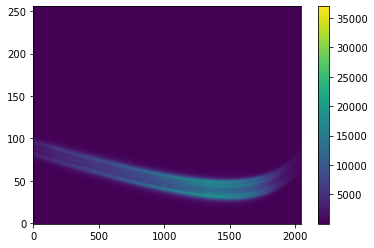

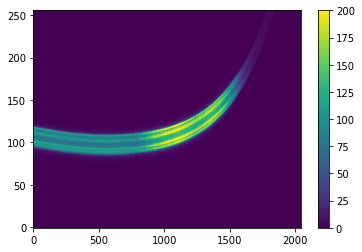

In [154]:
# Show the spatial profile models for each order.
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
plt.imshow(spat_prof_cv3.order1, origin='lower', aspect='auto')
plt.colorbar()
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
plt.imshow(spat_prof_cv3.order2, origin='lower', aspect='auto')
plt.colorbar()
ax2.set_xlabel('Spectral Pixel', fontsize=14)
ax2.set_ylabel('Spatial Pixel', fontsize=14)

plt.xlim(0, 2048)
plt.ylim(0, 256)

plt.subplots_adjust(hspace=0.02)
plt.show()